In [25]:
import torch
import random
import numpy as np
import torchvision.datasets

In [26]:
def init_seed():
    random.seed(0)
    np.random.seed(0)
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True

In [27]:
init_seed()

In [28]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [29]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [30]:
print(X_train.dtype, y_train.dtype)

X_train = X_train.float()
X_test = X_test.float()

print(X_train.dtype, y_train.dtype)

torch.uint8 torch.int64
torch.float32 torch.int64


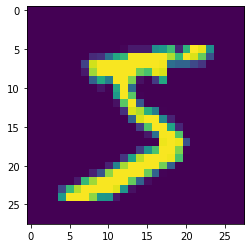

tensor(5)


In [31]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

### **Reshape данных. Из тензора матриц в тензор векторов**


In [32]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
torch.Size([60000]) torch.Size([10000])
torch.Size([60000, 784]) torch.Size([10000, 784])
torch.Size([60000]) torch.Size([10000])


In [33]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

## **Вычисления на GPU, если выполняем в colab**

In [34]:
# Проверяем, видит ли торч GPU
#torch.cuda.is_available()

In [35]:
# Проверяем, занята ли видеокарта вычислениями
#!nvidia-smi

In [36]:
# Перекладываем вычисления на видеокарту, если есть GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)

# смотрим, где лежат параметры
#list(mnist_net.parameters())

## **Train nn**

In [37]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [ ]:
batch_size = 100

# списки для построения графиков
test_accuracy_history = []
test_loss_history = []

# тестовую выборку перекладываем на видеокарту сразу (она небольшая)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(200):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        # перекладываем выборки по видеокарту по батчам
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

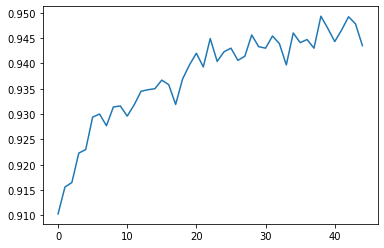

In [41]:
plt.plot(test_accuracy_history);

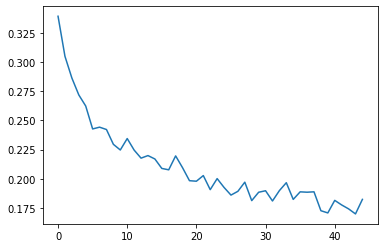

In [40]:
plt.plot(test_loss_history);